# Clustering

# Data Preparation Phase

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA


from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


### Data Preprocessing


In [2]:
segdat = pd.read_csv("/Desktop/segmentation data.csv")
segdat.head()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1


In [4]:
segdat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               2000 non-null   int64
 1   Sex              2000 non-null   int64
 2   Marital status   2000 non-null   int64
 3   Age              2000 non-null   int64
 4   Education        2000 non-null   int64
 5   Income           2000 non-null   int64
 6   Occupation       2000 non-null   int64
 7   Settlement size  2000 non-null   int64
dtypes: int64(8)
memory usage: 125.1 KB


In [5]:
# Check for missing values
segdat.isnull().sum()

ID                 0
Sex                0
Marital status     0
Age                0
Education          0
Income             0
Occupation         0
Settlement size    0
dtype: int64

In [6]:
# checking for duplicates
duplicates = segdat[segdat.duplicated()]
print(f"Number of duplicates: {len(duplicates)}")
duplicates

Number of duplicates: 0


,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size


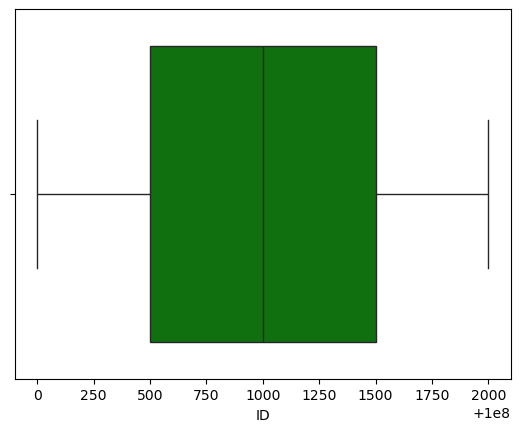

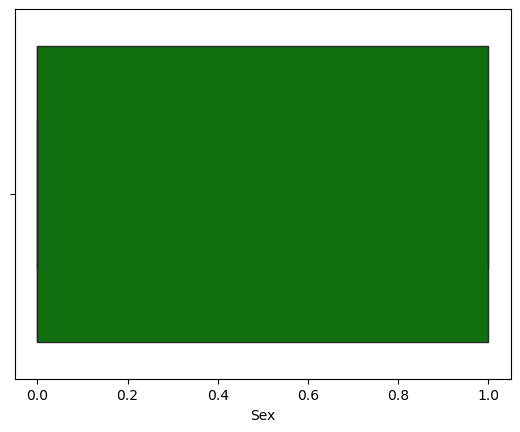

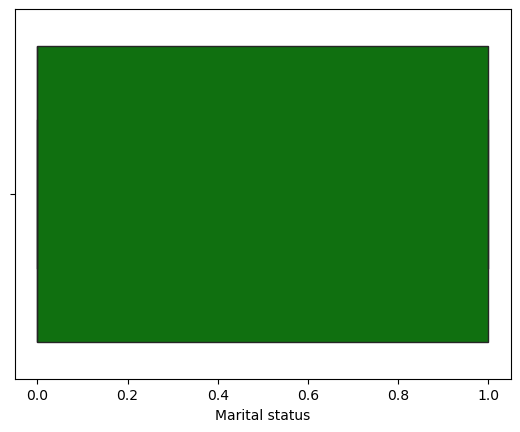

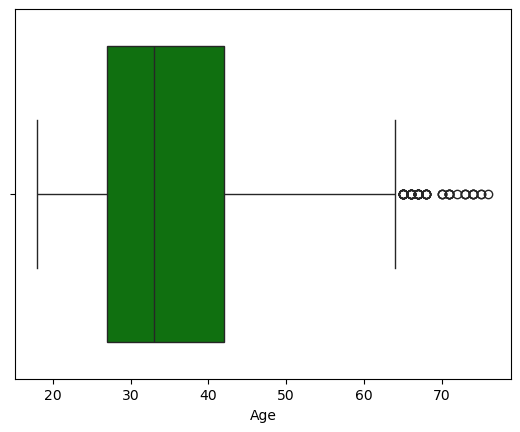

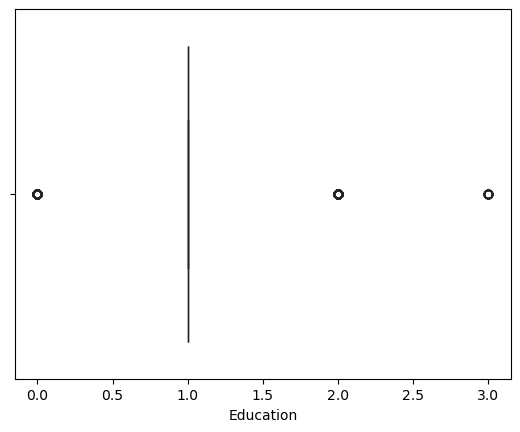

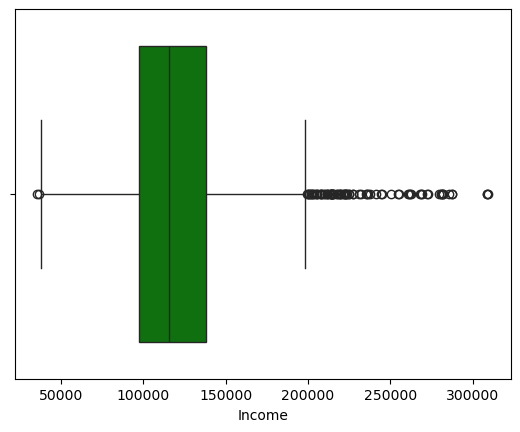

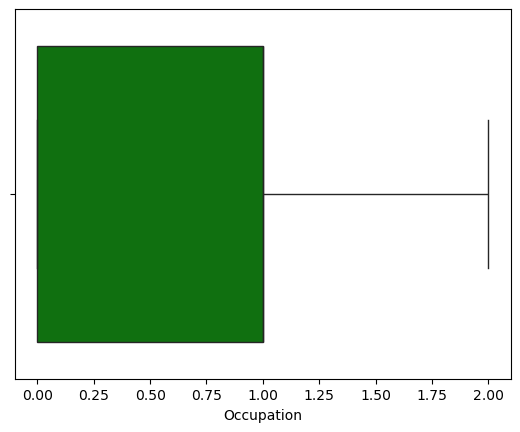

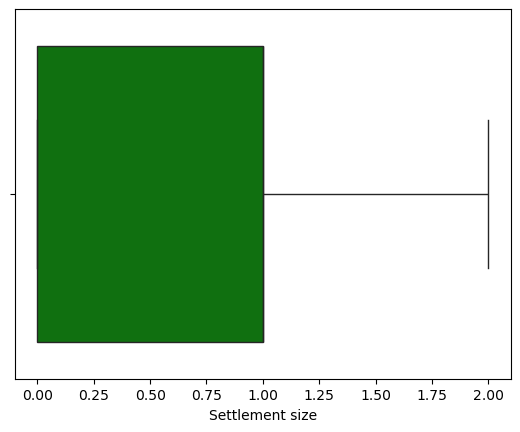

In [7]:
# check for Outliers in the numerical columns 

n_col = segdat.select_dtypes(exclude='object').columns
for i in n_col:
    sns.boxplot(segdat[i], orient='h', color='green')
    plt.show()

In [8]:
# Outliers detection and Removal

# Defining function to detect outliers
def detect_outliers(df, column):
    z_scores = stats.zscore(df[column])
    threshold = 3
    outliers = df[np.abs(z_scores) > threshold][column]
    return outliers

# Detect and print outliers for numeric columns
numeric_columns = segdat.select_dtypes(include=['int64', 'float64']).columns

print("Detected Outliers:")
for col in numeric_columns:
    outliers = detect_outliers(segdat, col)
    if not outliers.empty:
        print(f"\n{col} outliers:")
        print(outliers)



Detected Outliers:

Age outliers:
186     74
330     75
430     74
536     75
606     74
756     74
1005    73
1019    73
1027    72
1062    73
1064    76
Name: Age, dtype: int64

Education outliers:
186     3
219     3
536     3
554     3
723     3
779     3
883     3
976     3
987     3
1004    3
1005    3
1011    3
1015    3
1020    3
1026    3
1031    3
1035    3
1057    3
1060    3
1064    3
1067    3
1075    3
1076    3
1082    3
1086    3
1091    3
1095    3
1099    3
1316    3
1393    3
1397    3
1428    3
1432    3
1495    3
1572    3
1576    3
Name: Education, dtype: int64

Income outliers:
18      261952
87      241068
95      268340
105     244716
226     236264
272     244541
373     272314
374     309364
378     281923
381     260977
615     254449
714     255198
736     235417
744     250050
763     235660
818     279593
887     237799
915     308491
917     287247
921     268906
1003    280570
1022    267872
1028    262634
1029    287106
1033    281084
1037    273063
10

In [10]:
# This is expected in real-world datasets—high-income values often exhibit positive skewness,
# Older customers are uncommon but likely legitimate.
# education is fine 
# hence no need for outliers removal as it's unlikely the above values are actual outliers

# Exploratory Data Analysis (EDA)

In [9]:
# Summary Statistics
segdat.describe(include='number')

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,1.000010e+08,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,5.774946e+02,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,1.000000e+08,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,1.000005e+08,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,1.000010e+08,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000015e+08,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000020e+08,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


Text(0.5, 1.0, 'Correlation Heatmap')

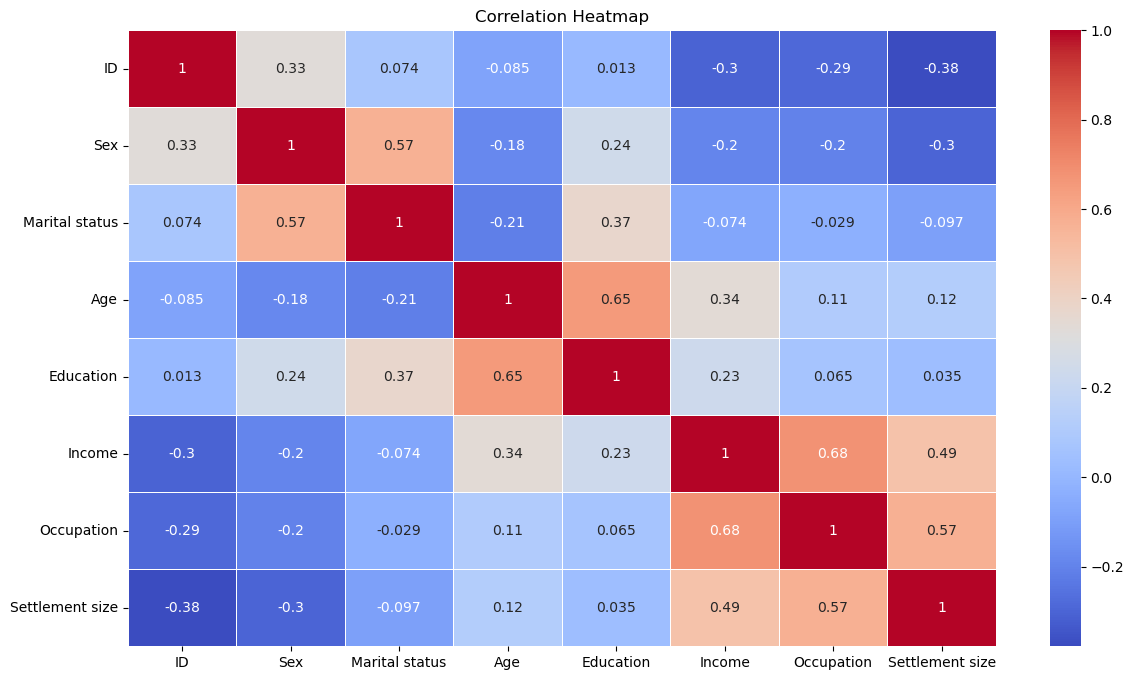

In [12]:
# Correlation Heatmap
plt.figure(figsize=(14, 8))  # Enlarging just the heatmap
sns.heatmap(segdat.corr(numeric_only=True), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")

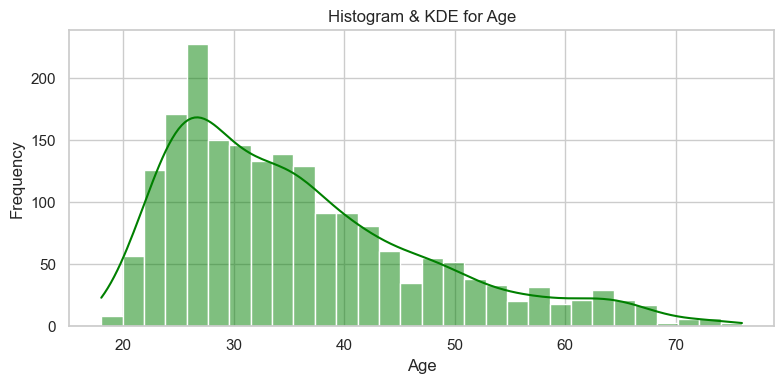

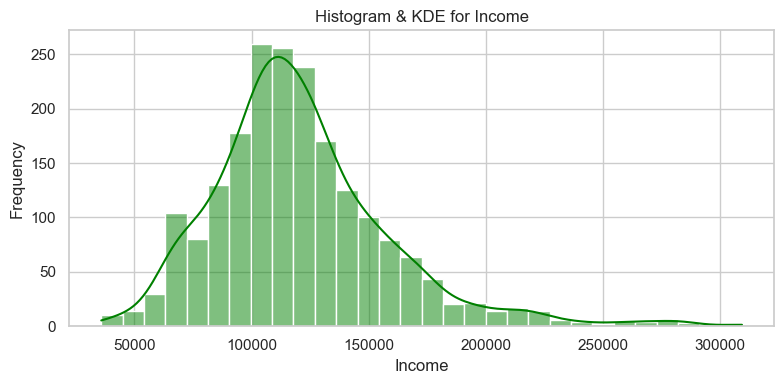

In [14]:
# Set visual style
sns.set(style="whitegrid")

# --- Histograms for continuous variables ---
continuous_vars = ['Age', 'Income']
for var in continuous_vars:
    plt.figure(figsize=(8, 4))
    sns.histplot(segdat[var], bins=30, kde=True, color='green')
    plt.title(f'Histogram & KDE for {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

/var/folders/9q/ftyr2fgd2bvbt44t3vyw232c0000gn/T/ipykernel_61398/808353474.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=segdat, x=var, palette='viridis')


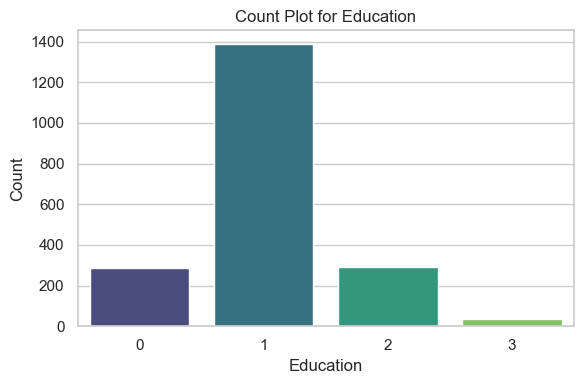

/var/folders/9q/ftyr2fgd2bvbt44t3vyw232c0000gn/T/ipykernel_61398/808353474.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=segdat, x=var, palette='viridis')


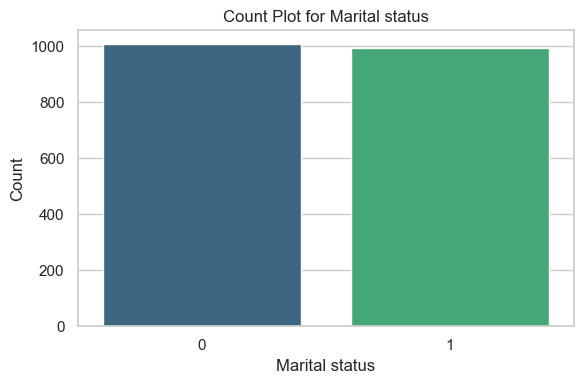

/var/folders/9q/ftyr2fgd2bvbt44t3vyw232c0000gn/T/ipykernel_61398/808353474.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=segdat, x=var, palette='viridis')


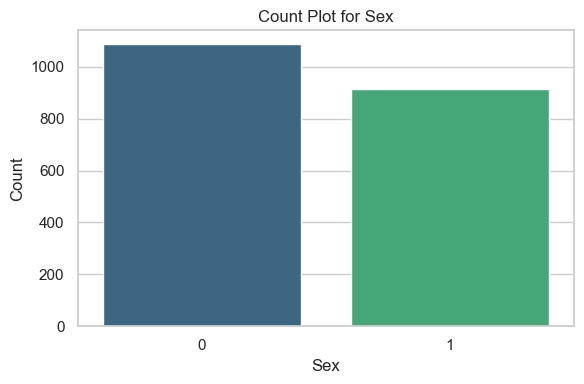

In [16]:
# --- Count plots for categorical variables ---
categorical_vars = ['Education', 'Marital status', 'Sex']
for var in categorical_vars:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=segdat, x=var, palette='viridis')
    plt.title(f'Count Plot for {var}')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# Modeling Phase and Evaluation

In [19]:
# selecting and scaling the features
features = ['Age', 'Income', 'Education', 'Marital status', 'Sex']
X = segdat[features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


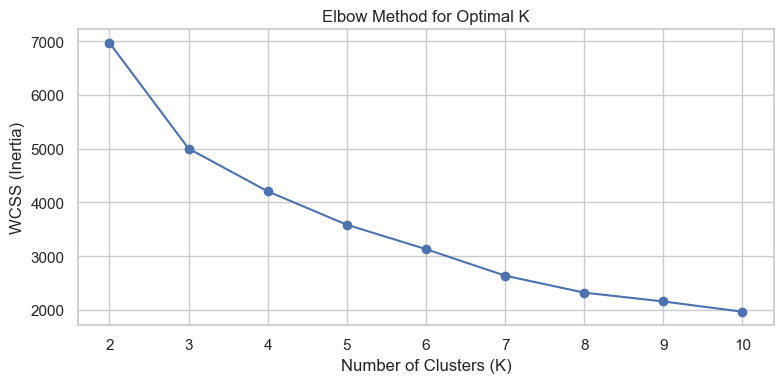

In [22]:
# Determining the Optimal Number of Clusters
# Elbow Method (WCSS)
inertia = []
K_range = range(2, 11)  # Try K from 2 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method for Optimal K')
plt.tight_layout()
plt.show()

In [29]:
# The "elbow" point where the curve flattens is the point the balances model simplicity and compact clusters (minimal inertia).
# The "elbow" appears at K = 4. This is the point where inertia reduction starts to level off.

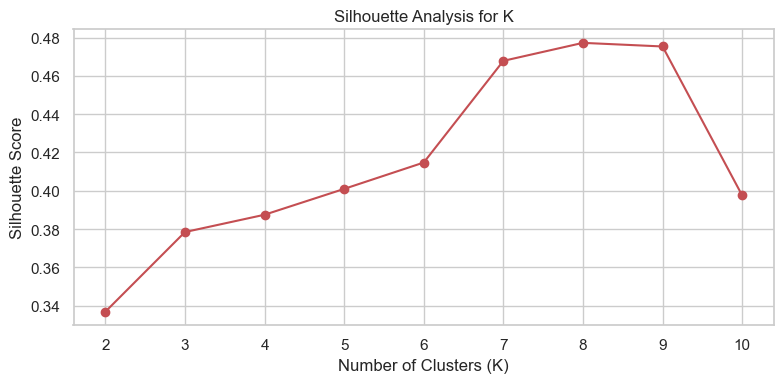

In [27]:
# Silhouette Score
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Plot the Silhouette Scores
plt.figure(figsize=(8, 4))
plt.plot(K_range, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for K')
plt.tight_layout()
plt.show()

In [28]:
# Higher silhouette score = better-defined clusters, the K with the highest score (or a stable peak)
# The highest score is at K = 8 

In [31]:
# Train the Final K-Means Model and Add Cluster Labels

# Train K-Means with K=8
kmeans_final = KMeans(n_clusters=8, init='k-means++', n_init=10, random_state=42)
segdat['Cluster'] = kmeans_final.fit_predict(X_scaled)

# Preview updated dataset
print(segdat[['Age', 'Income', 'Education', 'Marital status', 'Sex', 'Cluster']].head())


   Age  Income  Education  Marital status  Sex  Cluster
0   67  124670          2               0    0        5
1   22  150773          1               1    1        2
2   49   89210          1               0    0        3
3   45  171565          1               0    0        3
4   53  149031          1               0    0        3


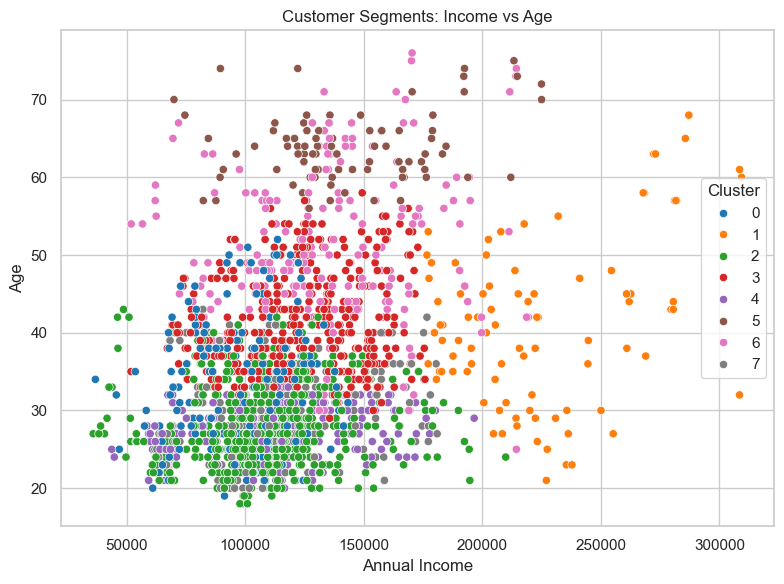

In [32]:
# Plot 1: Income vs Age
plt.figure(figsize=(8, 6))
sns.scatterplot(data=segdat, x='Income', y='Age', hue='Cluster', palette='tab10')
plt.title('Customer Segments: Income vs Age')
plt.xlabel('Annual Income')
plt.ylabel('Age')
plt.tight_layout()
plt.show()

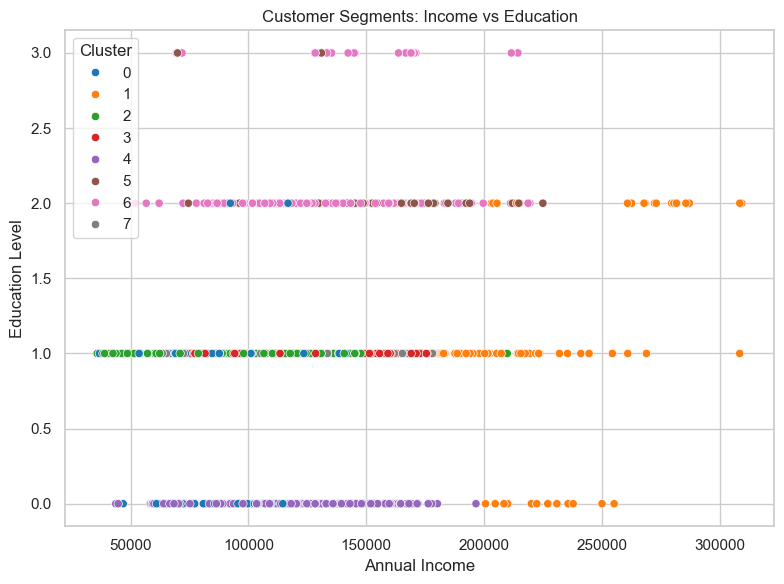

In [33]:
# Plot 2: Income vs Education
plt.figure(figsize=(8, 6))
sns.scatterplot(data=segdat, x='Income', y='Education', hue='Cluster', palette='tab10')
plt.title('Customer Segments: Income vs Education')
plt.xlabel('Annual Income')
plt.ylabel('Education Level')
plt.tight_layout()
plt.show()

In [34]:
kmeans_4 = KMeans(n_clusters=4, init='k-means++', n_init=10, random_state=42)
segdat['Cluster_4'] = kmeans_4.fit_predict(X_scaled)


In [38]:
## Evaluating the performance of the clusters 
sil = silhouette_score(X_scaled, segdat['Cluster'])
ch = calinski_harabasz_score(X_scaled, segdat['Cluster'])
db = davies_bouldin_score(X_scaled, segdat['Cluster'])

print(f"Silhouette Score (K=4): {sil:.4f}")
print(f"Calinski-Harabasz Score (K=4): {ch:.2f}")
print(f"Davies-Bouldin Score (K=4): {db:.4f}")

Silhouette Score (K=4): 0.4772
Calinski-Harabasz Score (K=4): 941.99
Davies-Bouldin Score (K=4): 0.8830


In [35]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

sil_4 = silhouette_score(X_scaled, segdat['Cluster_4'])
ch_4 = calinski_harabasz_score(X_scaled, segdat['Cluster_4'])
db_4 = davies_bouldin_score(X_scaled, segdat['Cluster_4'])

print(f"Silhouette Score (K=4): {sil_4:.4f}")
print(f"Calinski-Harabasz Score (K=4): {ch_4:.2f}")
print(f"Davies-Bouldin Score (K=4): {db_4:.4f}")


Silhouette Score (K=4): 0.3875
Calinski-Harabasz Score (K=4): 916.85
Davies-Bouldin Score (K=4): 1.0702


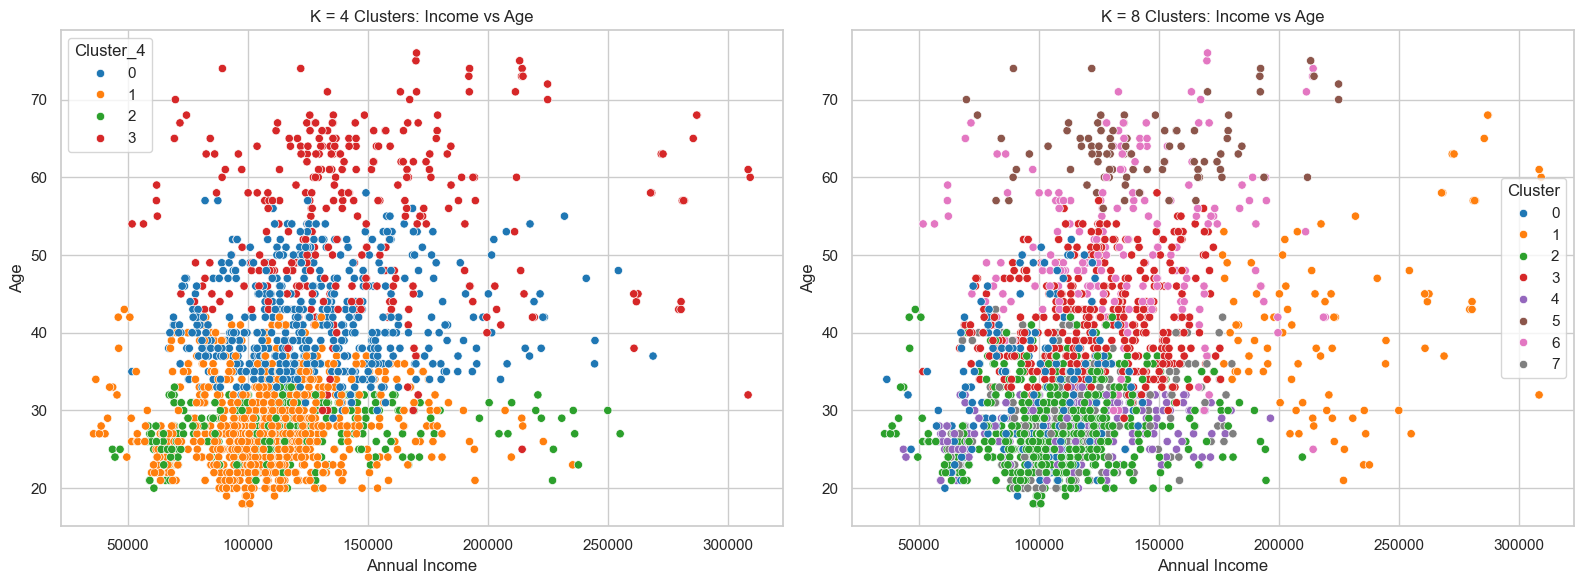

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure K=4 and K=8 cluster labels exist in df
# df['Cluster_4'] and df['Cluster'] (or df['Cluster_8'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- K = 4 ---
sns.scatterplot(data=segdat, x='Income', y='Age', hue='Cluster_4', palette='tab10', ax=axes[0])
axes[0].set_title("K = 4 Clusters: Income vs Age")
axes[0].set_xlabel("Annual Income")
axes[0].set_ylabel("Age")

# --- K = 8 ---
sns.scatterplot(data=segdat, x='Income', y='Age', hue='Cluster', palette='tab10', ax=axes[1])
axes[1].set_title("K = 8 Clusters: Income vs Age")
axes[1].set_xlabel("Annual Income")
axes[1].set_ylabel("Age")

plt.tight_layout()
plt.show()
